## 1. Loading and Exploring Time Series Data
We'll use **sktime** datasets for richer time series analysis.

In [71]:
from sktime.datasets import load_airline
import pandas as pd
df = load_airline()
df = pd.DataFrame(df)
df.columns = ['y']
df.head()

,y
Period,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


## 2. Simulating and Handling Missing Data
We'll create missing values and explore **multiple imputation methods**.

In [72]:
import numpy as np
np.random.seed(0)
m = df.shape[0]
mask = np.random.choice([True, False], size=m, p=[0.1,0.9])
df_missing = df.copy()
df_missing.loc[mask] = np.nan
df_missing.isna().sum()

y    13
dtype: int64

/tmp/ipykernel_269639/445330719.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df_missing.fillna(method='ffill')


<Axes: title={'center': 'Forward Fill Imputation'}, xlabel='Period'>

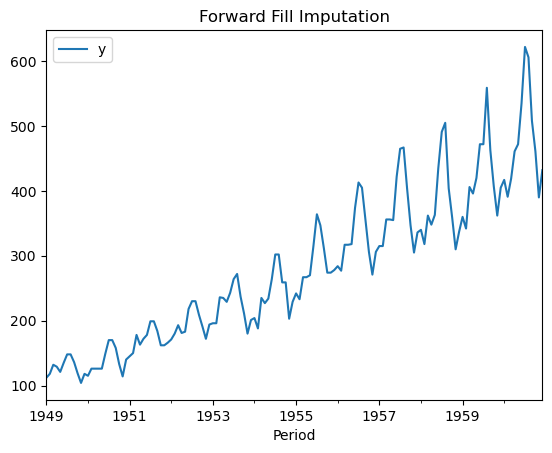

In [73]:
df_ffill = df_missing.fillna(method='ffill')
df_ffill.plot(title='Forward Fill Imputation')

/tmp/ipykernel_269639/767277528.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bfill = df_missing.fillna(method='bfill')


<Axes: title={'center': 'Backward Fill Imputation'}, xlabel='Period'>

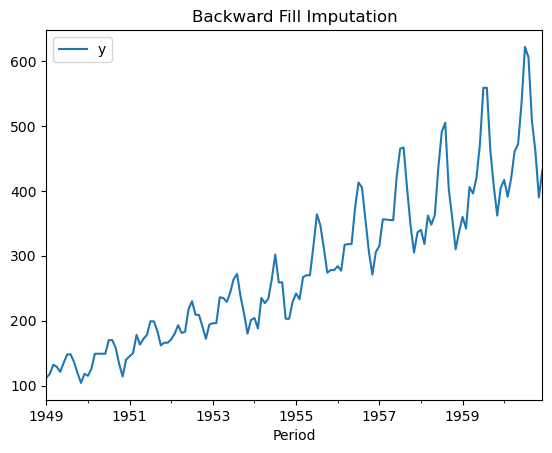

In [74]:
df_bfill = df_missing.fillna(method='bfill')
df_bfill.plot(title='Backward Fill Imputation')

<Axes: title={'center': 'Interpolation Imputation'}, xlabel='Period'>

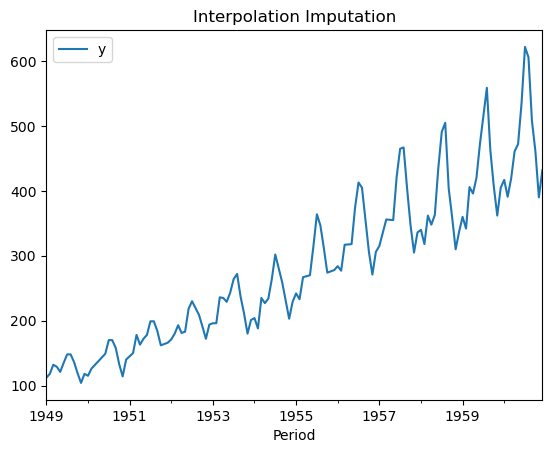

In [75]:
df_interp = df_missing.interpolate()
df_interp.plot(title='Interpolation Imputation')

## 3. Resampling and Aggregation
We'll aggregate monthly data to quarterly.

In [76]:
df_q_sum = df_ffill.resample('Q').sum()
df_q_mean = df_ffill.resample('Q').mean()
df_q_sum.head(), df_q_mean.head()

/tmp/ipykernel_269639/997777352.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  df_q_sum = df_ffill.resample('Q').sum()
/tmp/ipykernel_269639/997777352.py:2: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  df_q_mean = df_ffill.resample('Q').mean()


(            y
 Period       
 1949Q1  362.0
 1949Q2  385.0
 1949Q3  432.0
 1949Q4  341.0
 1950Q1  367.0,
                  y
 Period            
 1949Q1  120.666667
 1949Q2  128.333333
 1949Q3  144.000000
 1949Q4  113.666667
 1950Q1  122.333333)

## 4. Decomposition
Split data into trend, seasonality, residuals using sktime. (Hint: Try to use exmaple from the documenation)

In [77]:
from sktime.datasets import load_airline
from sktime.transformations.series.detrend import STLTransformer
X = load_airline()  # doctest: +SKIP
transformer = STLTransformer(sp=12)  # doctest: +SKIP
#Xt = transformer.fit_transform(X)  # doctest: +SKIP
#Xt

Big libraries might experice some problems that is why the require unit-tetsing, let's do this using statsmodels

In [80]:
res.trend

date
1959-01-01    315.565053
1959-02-01    315.657961
1959-03-01    315.752224
1959-04-01    315.847357
1959-05-01    315.942715
                 ...    
1987-08-01    348.837635
1987-09-01    349.015529
1987-10-01    349.195335
1987-11-01    349.377006
1987-12-01    349.560301
Name: trend, Length: 348, dtype: float64

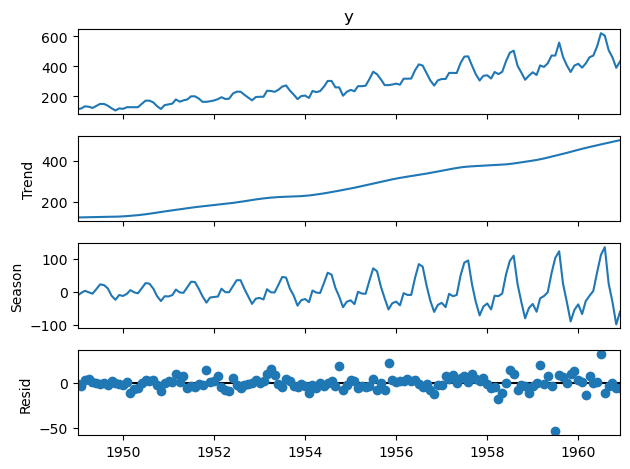

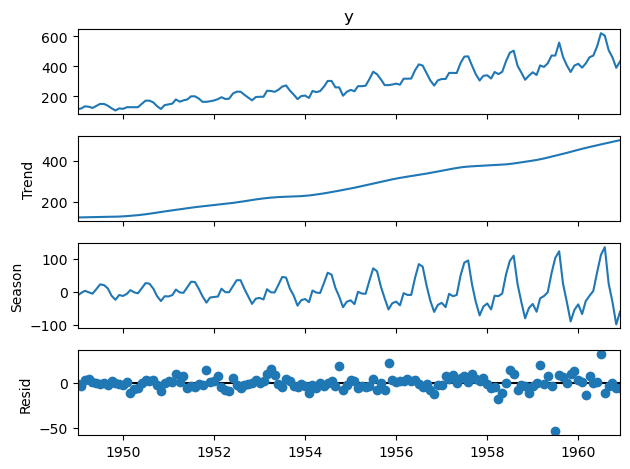

In [81]:
from statsmodels.tsa.seasonal import STL
from copy import deepcopy

y_series = deepcopy(df_ffill['y'])
y_series.index = y_series.index.to_timestamp() 

# Perform STL decomposition
stl_mod = STL(y_series)
result = stl_mod.fit()
result.plot()

## 5. Outlier Detection
Identify outliers using z-scores and the Hampel filter.

In [84]:
from scipy.stats import zscore

df_filled=deepcopy(df_ffill)
z_scores = np.abs(zscore(df_filled))
outliers_z = z_scores > 3
df_filled['z_outlier'] = outliers_z
df_filled['z_outlier']

Period
1949-01    False
1949-02    False
1949-03    False
1949-04    False
1949-05    False
           ...  
1960-08    False
1960-09    False
1960-10    False
1960-11    False
1960-12    False
Freq: M, Name: z_outlier, Length: 144, dtype: bool

In [ ]:
def hampel(series, window_size=7, n_sigmas=3):
    k = 1.4826  # scale factor for Gaussian distribution
    new_series = series.copy()
    rolling_median = series.rolling(window=2*window_size, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_mad = series.rolling(window=2*window_size, center=True).apply(MAD)
    threshold = n_sigmas * k * rolling_mad
    diff = np.abs(series - rolling_median)
    outlier_idx = diff > threshold
    return outlier_idx

hampel_outliers = hampel(df_filled['y'])
df_filled['hampel_outlier'] = hampel_outliers
print(df_filled['hampel_outlier'].sum())

0


In [89]:
residue = deepcopy(result.resid)

z_scores_res = np.abs(zscore(residue))
z_scores_res >3

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,